<a href="https://colab.research.google.com/github/SaketMunda/dog-breed-prediction/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm travelling somewhere outside in any part of the country, and I see different dogs take pictures of them, I want to know the breed of that dog.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set. (these image have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


In [ ]:
# Unzip the data in google drive
# !unzip "drive/MyDrive/Data Science/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Data Science/Dog Vision"

## Get our workspace ready

* Import TensorFlow ✅
* Import TensorFlow Hub ✅
* Make sure GPU is running ✅

In [2]:
# Importing the TensorFlow hub

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)


# Check for GPU availability
print("GPU", "available (Yess !!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


TF version: 2.8.2
TF Hub version: 0.12.0
GPU not available :(


## Getting our data ready (turning into Tensors)

With all the machine learning models, our data has to be in numerical format. So that's what we'll be doing first(numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Data Science/Dog Vision/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

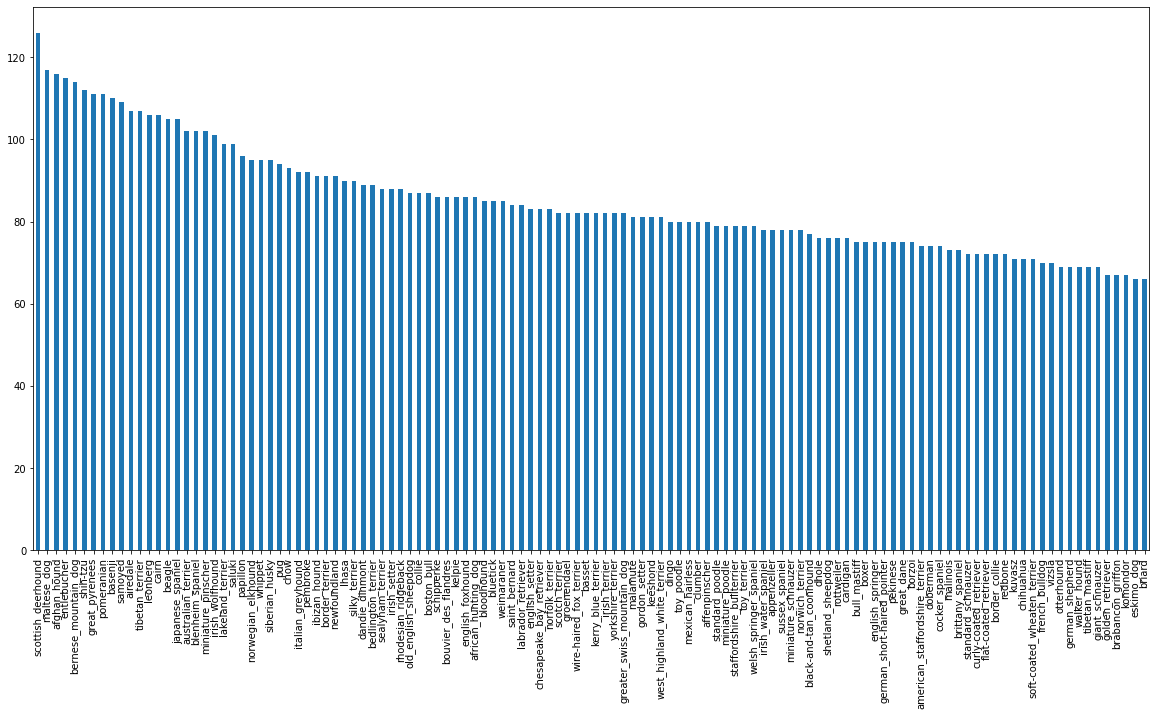

In [ ]:
# Check the distribution of samples per class
labels_csv["breed"].value_counts().plot.bar(figsize =(20, 10));

In [ ]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

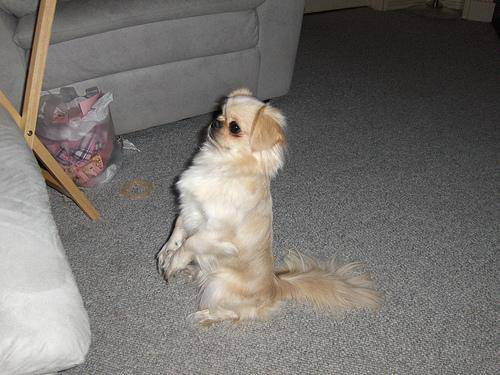

In [ ]:
# Let's view an Image
from IPython.display import Image
Image("drive/MyDrive/Data Science/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg")

## Getting images and their labels

Let's get a list of all of our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# Create pathnames from Image's Id

filenames = ["drive/MyDrive/Data Science/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/Data Science/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Compare the label counts available in csv with the amount of files/images available in train folder
import os
if len(os.listdir("drive/MyDrive/Data Science/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed


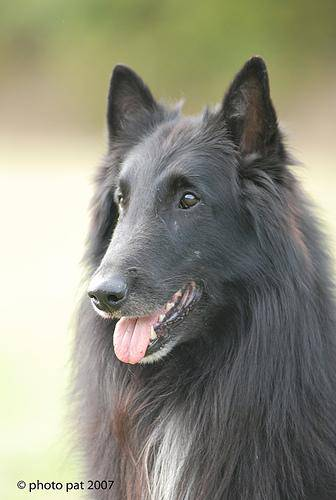

In [ ]:
# One more check
Image(filenames[8500])

In [ ]:
labels_csv["breed"][8500]

'groenendael'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [5]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# check the count of labels or missing data
if len(labels) == len(filenames):
  print("We have same amount of labels and files")
else:
  print("Some labels or files are missing, they don't match")

We have same amount of labels and files


In [6]:
# Find the unique labels
import numpy as np
unique_breeds = np.unique(labels)

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[2])
print(labels[2]==unique_breeds)
print(labels)

pekinese
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [7]:
# Turn every label into a boolean array
boolean_label = [label == unique_breeds for label in labels]
boolean_label[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_label)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_label[0].argmax()) # index where label occurs in boolean array
print(boolean_label[0].astype(int)) # converting the array into integer

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_label[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own Validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [8]:
# Setup X & y variables
X = filenames
y = boolean_label

We're going to start off experimenting with ~1000 images and increase as needed.

In [9]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [10]:
# Spliting into Train and Valid set

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:2], y_train[:2]

(['drive/MyDrive/Data Science/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Data Science/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False

## Preprocessing Images (Turning Images into Tensors) <-- Tensors because we are using tensorflow

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize the tensors by converting it from the range of 0-255 to 0-1
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

Tutorial : https://www.tensorflow.org/tutorials/load_data/images

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert an image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape 
# imread converted image into an array of the combination of (R, G, B)
# which ranges from 0 to 255

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# let's convert it to tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [11]:
# writing the preprocess image function
#1. Take an image filepath as input
#2. Use TensorFlow to read the file and save it to a variable, `image`
#3. Turn our `image` (a jpg) into Tensors
#4. Normalize the tensors by converting it from the range of 0-255 to 0-1
#5. Resize the `image` to be a shape of (224,224)
#6. Return the modified `image`

IMG_SIZE = 224

def preprocess_image(image_path, img_size = IMG_SIZE):
  """
  This function take image path and image size as input and turn them into tensors.
  """

  # read the image file from the image path and assign it to a variable
  image = tf.io.read_file(image_path) # this convert it to string or special characters, no readable
  # Turn the jpeg image into numerical tensors with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalize the colour channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to be a shape of (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning into batches

Why turn our data into batches ?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [12]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  process the image and convert the label into Tensors and return a tuple of (image, label).
  """
  return preprocess_image(image_path), label

In [ ]:
# check if it is working for single image
demo_tensor = get_image_label(X[42], y[42])
demo_tensor

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)`, let's make a function to turn the data into batches!

In [13]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no label)
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating batches for test data....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(preprocess_image).batch(batch_size)
    return data_batch
  # if the data is validation dataset, we do have labels but we don't need to shuffle it
  elif valid_data:
    print("Creating batches for validation data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating batches for Training data....")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image) and turn them into batches
    data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch 


In [14]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val,y_val, valid_data=True)

Creating batches for Training data....
Creating batches for validation data...


In [16]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. Let's plot it

In [26]:
# Create function to plot the images with it's labels

import matplotlib.pyplot as plt

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # display an image
    plt.imshow(images[i])
    # add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


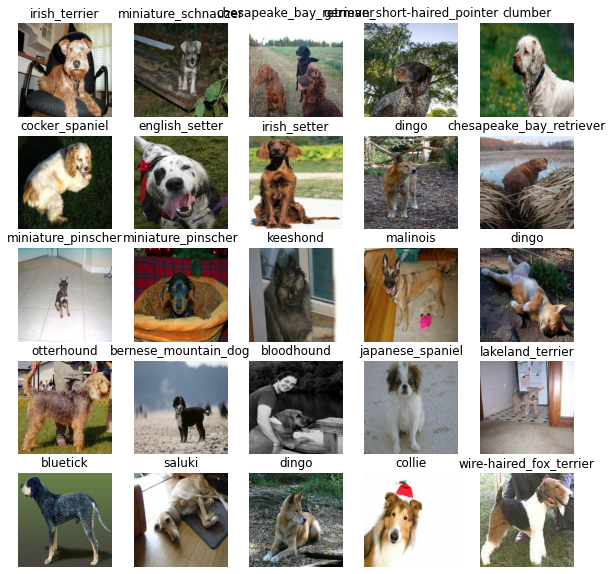

In [29]:
# next() will pop a batch of 32 images, as_numpy_iterator will convert the batch into iteration so that next can pop the batch
# ploting the train set
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# everytime we run this block will produce new set of images, because we used the shuffle for training set

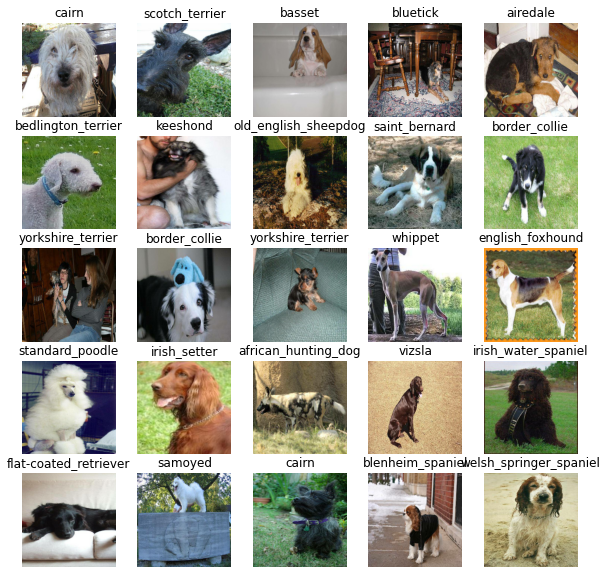

In [31]:
# visualizing the validation set
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images,valid_labels)